# Pipeline final pour l'entreprise **TouNum**

L'entreprise TouNum travaille sur la numérisation de documents (textes, images...). Leurs services sont souvent requis par des entreprises numérisant leur base de documents papier. Ils souhaitent étendre leur gamme de services pour inclure des outils de Machine Learning. En effet, certains de leurs clients ont une grande quantité de données à numériser, et un service de catégorisation automatique serait plus que valorisable.

Cette pipeline sert donc à remplir l'objectif de TouNum, pour cela elle est divisée en 3 grande partie :
1. Classification d'image selon 5 catégories [Photo, Peinture, Schéma, Croquis, Texte]

2. Débruitage des images classifiées "Photo", suppresion de 4 types de bruits : [Gaussian, Poisson, Speckles, Salt & pepper]
   
3. Génération des descriptions pour les photos débruitées.

Format des données d'entrées attendues :
- **Chemin des données d'entrée :** `datas_path` (actuellement défini comme `./Dataset/test_final`)
- **Exemple de fichiers attendus dans le dossier :**
    - `datas_path/img01.png`
    - `datas_path/img02.jpg`
    - ...


---
## Dépendances

Chargement des différentes dépendances nécessaires au bon fonctionnement de la pipeline, ainsi que de la configuration de la pipeline.

In [1]:
# Import des dépendances
import os
import sys

# Ajouter le dossier courant au path si nécessaire pour accéder à notre librairies utils.py
sys.path.append(os.getcwd())
import utils

In [ ]:
# Configuration Principale
datas_path = "./Dataset/test_final" # Dossier de stockage des données qui sont des images

# Partie 2 : Autoencoder
autoencoder_weights_path = "./checkpoints/modelGaus_epoch46_valLoss0.0041.h5" # Chemin du stockage des poids de l'autoencoder

# Partie 3 : captionning
save_dir = './checkpoints/train'  
token_dir = './saved_model_captioning'  
max_length = 7

---
## Partie 1 : Classification de photo (Livrable 1)

Dans cette partie, nous allons charger notre modèle de classification d'images capable de distinguer entre 5 catégories : [Photo, Peinture, Schéma, Croquis, Texte]. 

Pour ce faire, nous allons suivre les étapes suivantes :
1. Préparation des données : collecte, nettoyage et augmentation des données pour chaque catégorie.
2. Chargement du modèle : utilisation d'un réseau de neurones convolutionnel (CNN) pour effectuer la classification.
3. Classification des données réelles : Classification des images fournies par l'entreprise TouNum. 
4. Visualisation des résultats : Visualisations de plusieurs résultats de notre modèle.

L'objectif est de fournir un modèle robuste et performant qui pourra être intégré dans la pipeline globale de l'entreprise.

### 1.1 Préparations des données
Chargement et nettoyage de celle-ci.

In [3]:
# Affichages des statistiques des images
images_count = utils.get_infos_datas(datas_path)

Nombre total d'images : 56


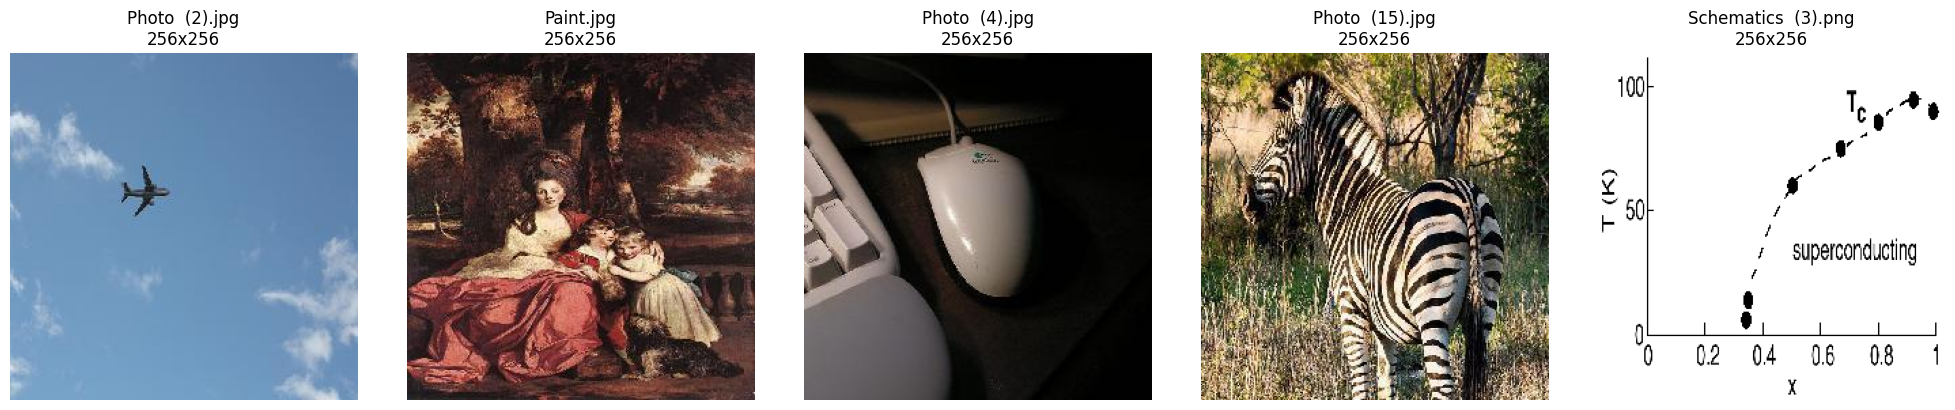

In [4]:
# Affichage de quelques images
utils.display_random_images(datas_path,5)

In [5]:
# Nettoyage des données
utils.clean_images_dataset(datas_path)

Début de la vérification des images ...
Progression : [100%] 56/56 images vérifiées
Vérification des fichiers terminée.
Nombre total d'images corrompues ou non image : 0


Début du redimensionnement des images ...
Progression : [100%] 56/56 images redimensionnées
Redimensionnement des fichiers terminé.


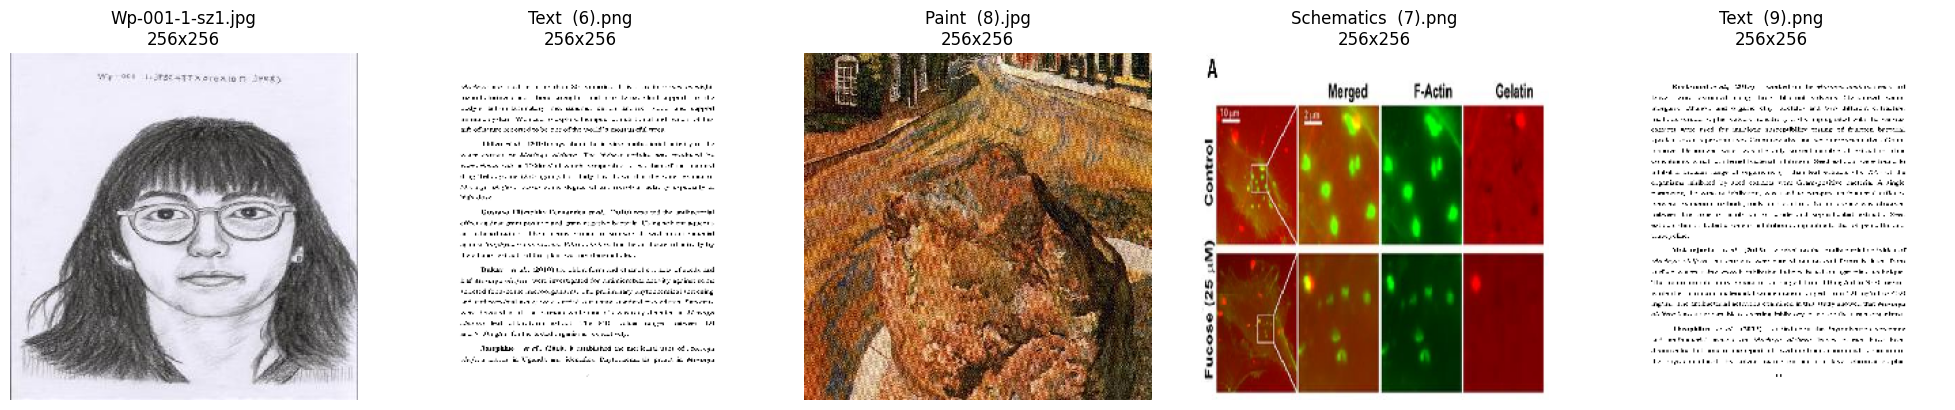

In [6]:
# Redimensionnement des images en 256, 256
utils.resize_images_dataset(datas_path, (256, 256))

# Affichage de quelques images après redimensionnement
utils.display_random_images(datas_path,5)


### 1.2 Chargement du modèle
Chargement de notre modèle précèdement entrainé.

In [7]:
# Chargement de notre modèle le plus performant ()
model = utils.load_model("./Backup model/Livrable 1/model_Categorical_modified2.h5")

Modèle chargé depuis ./Backup model/Livrable 1/model_Categorical_modified2.h5


### 1.3 Classification des données
Classification des images selon les 5 catégories ()

In [8]:
# Classification des images (stocker les images de types "Photo")
list_photos = utils.get_predicted_photos(model, datas_path)

Traitement de 56 images...


Prédiction en cours:   0%|          | 0/56 [00:00<?, ?image/s]


✅ 10 images classées comme 'Photo'.


### 1.4 Affichage de quelques résultats

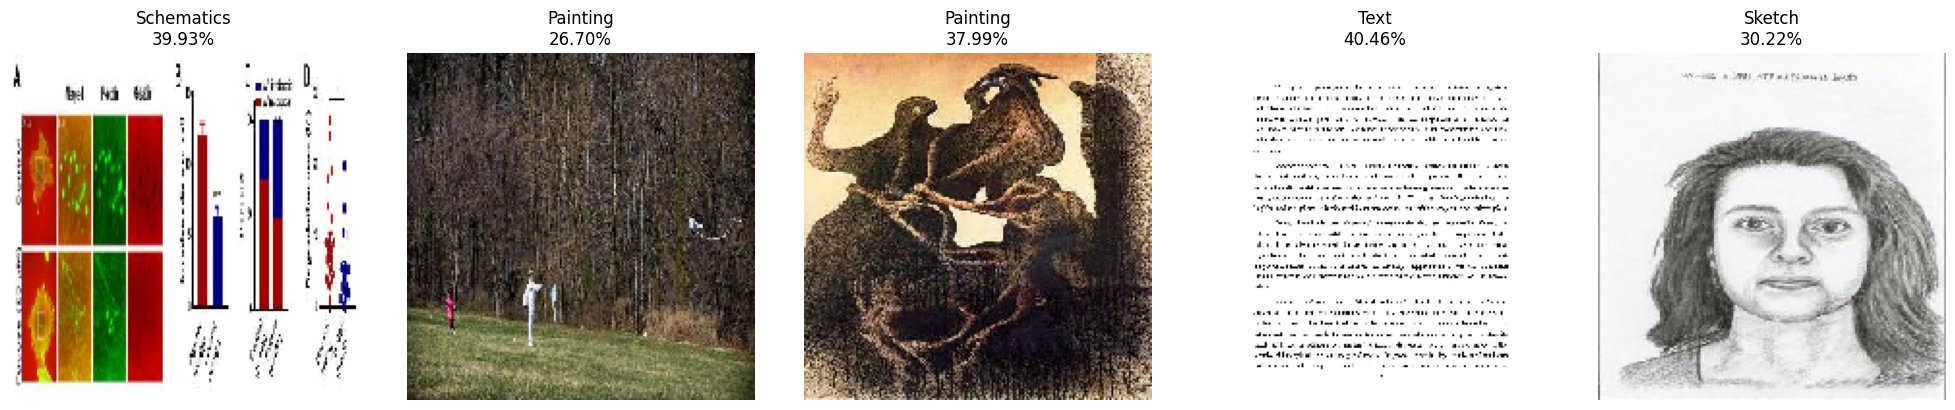

In [9]:
# Affichage de quelques images après classification
utils.display_images_with_predictions(model, datas_path, 5)

---
## Partie 2 : Débruitage de nos images (Livrable 2)

Dans cette partie, nous allons utiliser notre modèle de débruitage d'images pour les images classifiées comme "Photo". L'objectif est de supprimer efficacement les bruits présents dans les images tout en préservant leurs détails importants. Les étapes suivantes seront suivies :

1. Chargment de notre autoencoder : chargemnt de notre autoencoder le plus performant. 
2. Débruitage de nos images : débruitages des images catégorisées photos, grâce à notre model de classification.
3. Visualtion des résulats : affichage d'échantillons de nos images débruitées.

L'objectif est de fournir des images de haute qualité prêtes pour l'étape suivante de la pipeline.

### 2.1 Chargement de l'autoencoder
On charge notre autoencoder le plus performant. (générique)

In [10]:
autoencoder = utils.load_autoencoder(autoencoder_weights_path)
autoencoder.summary()

Autoencodeur chargé depuis ./checkpoints/modelGaus_epoch46_valLoss0.0041.h5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 16)   │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 256, 256, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,349 (52.15 KB)

 Trainable params: 13,347 (52.14 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

### 2.2 Débruitage des images

In [11]:
# Charger les images à partir des chemins
loaded_images = utils.load_images_from_paths(list_photos)
loaded_images = utils.resize_images(loaded_images, (256, 256))
loaded_images = utils.preprocess_data(loaded_images)

In [12]:
images_denoised = utils.denoise_images(autoencoder, loaded_images)

Prédiction réussie.


### 2.3 Résultats de débruitage
Affichage d'échantillons d'images denoised

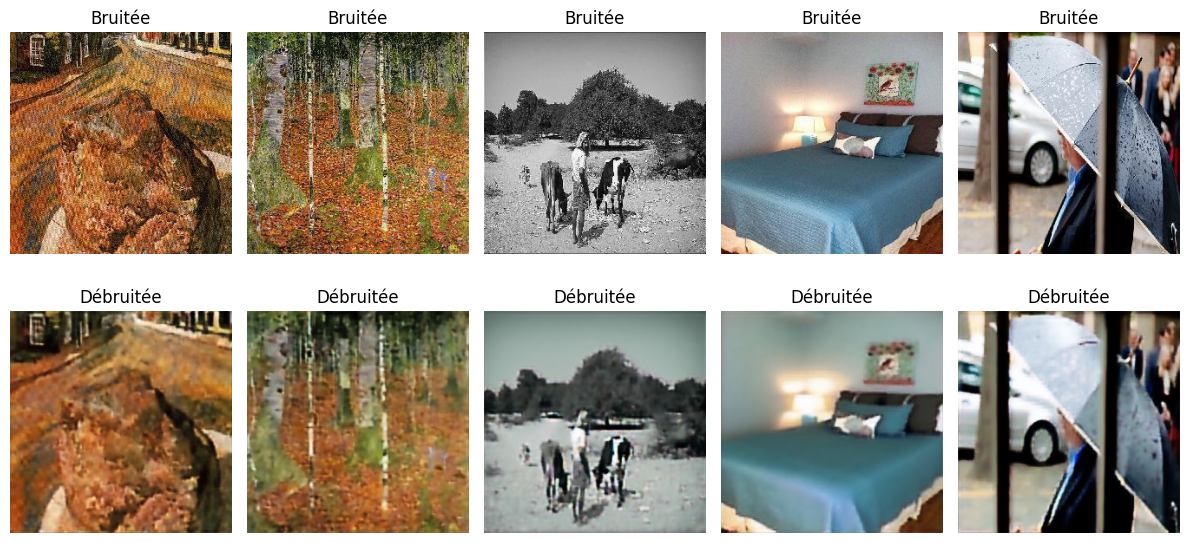

In [13]:
utils.plot_denoised_examples(loaded_images, images_denoised)

## Partie 3 : Captionning d'images (Livrable 3)
Dans cette partie, nous allons utiliser un modèle de génération de descriptions (captionning) pour les images débruitées. L'objectif est de produire des descriptions textuelles pertinentes pour chaque image, facilitant ainsi leur compréhension et leur utilisation. Les étapes suivantes seront suivies :

1. Chargement du modèle de captionning : utilisation d'un modèle pré-entraîné pour la génération de descriptions.
2. Génération des descriptions : application du modèle sur les images débruitées pour produire des descriptions textuelles.
3. Visualisation des résultats : affichage des descriptions générées pour un échantillon d'images.

### 3.1 Chargement du modèle de captionning

In [ ]:
# Chargement du modèle de captionning
Load_encoder, Load_decoder, image_features_extract_model, tokenizer = utils.load_model_caption(token_dir, save_dir)

Checkpoint restauré depuis ./checkpoints/train\ckpt-12


### 3.2 Captionning des images
Ajout d'une descriptions pour les images

In [ ]:
# Captionning des images denoisées
captions = []
for idx, image_array  in enumerate(images_denoised):
    caption = utils.generate_caption_from_array(image_array, Load_encoder, Load_decoder, image_features_extract_model, tokenizer, max_length)
    captions.append(caption)

### 3.3 Résultats du captionning
Affichage des descriptions générées pour les images.

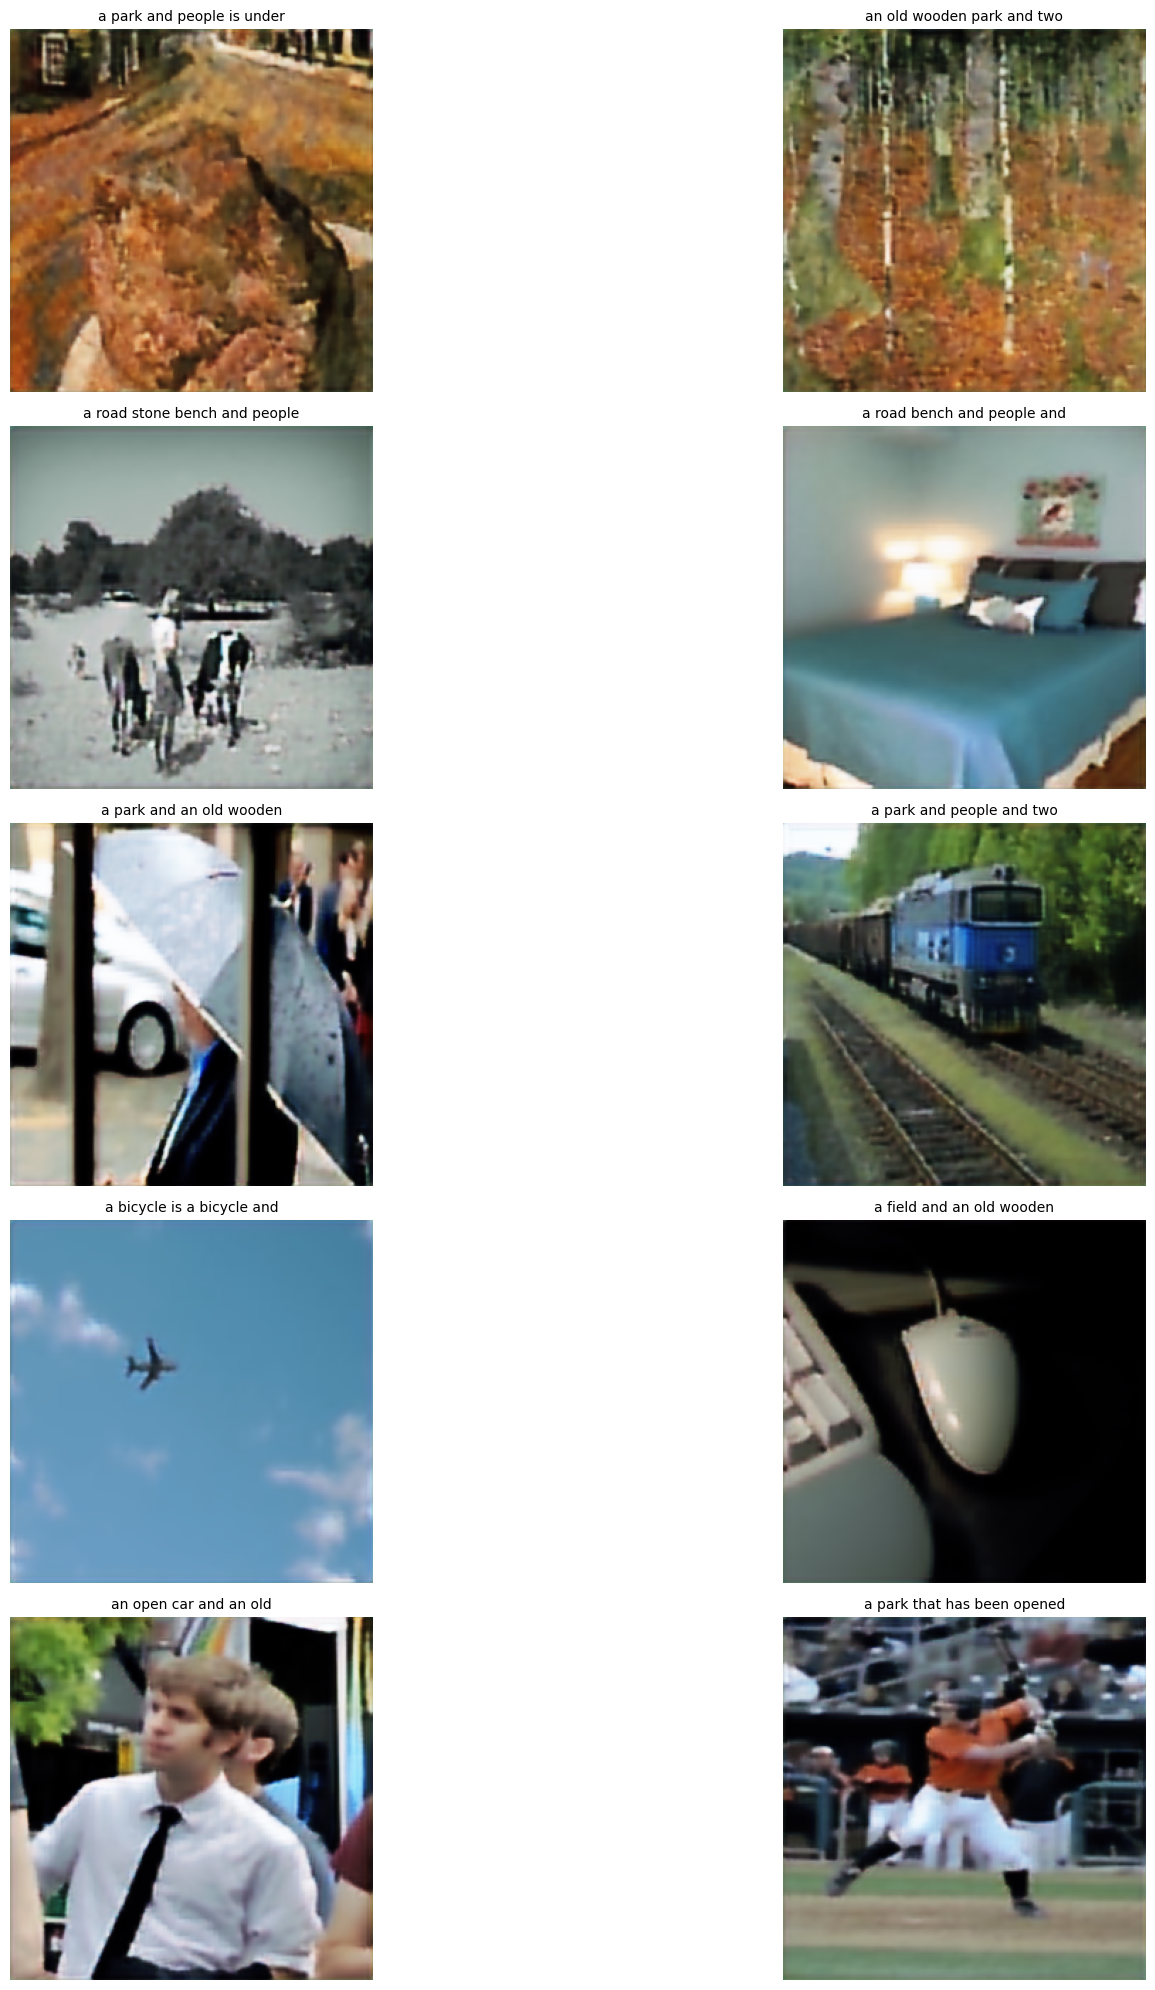

In [ ]:
# Affichage des résultats de captionning
utils.plot_captionned_images(images_denoised, captions, 5)